# Chapter 9: Up and Running with Tensorflow

## Creating Your First Graph and Running It in a Session

In [0]:
# A computational graph with Tensorflow. Despite the code's appearance,
# this does not perform any computation.

import tensorflow as tf

x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = (x * x * y) + y + 2

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Running the computational graph in a Tensorflow Session.

sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


In [0]:
# Another way to execute the code above. It automatically closes the Session.

with tf.Session() as sess:
  x.initializer.run() # Same as tf.get_default_session().run(x.initializer)
  y.initializer.run()
  result = f.eval()
  print(result)

42


In [0]:
# It is possible to initialize all variables automatically.

init = tf.global_variables_initializer()

with tf.Session() as sess:
  init.run()
  result = f.eval()
  print(result)

42


In [0]:
# InteractiveSession is useful for Jupyter notebooks because it sets itself
# as the default session automatically.

sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


## Managing Graphs

In [0]:
# New Variables are always added to the default graph automatically.

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [0]:
# Below is the syntax for adding a variable to a graph that is not
# the default graph.

graph = tf.Graph()
with graph.as_default():
  x2 = tf.Variable(2)
x2.graph is graph

True

In [0]:
x2.graph is tf.get_default_graph()

False

## Lifecycle of a Node Value

In [0]:
# Tensorflow automatically detects the dependency chain between nodes of
# the computation graph.

w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
  # detects that y dependes on x, which depends on w. So it evaluates
  # w, then x, then y.
  print(y.eval())
  print(z.eval())

10
15


## Linear Regression with Tensorflow

Tensorflow operates with multidimensional arrays called <i>tensors</i>. The Python API uses NumPy's `ndarray` class to represent tensors. The previous examples used a single scalar value for a tensor. Below is an example of a Tensorflow graph which operates on a 2D array performing linear regression. Recall that the optimal parameters for Linear Regression, $\hat{\theta}$ is given by

$$ \hat{\theta} = \left( \mathbf{X}^{\,T} \cdot \mathbf{X} \right)^{-1} \cdot \mathbf{X}^{\,T} \cdot \mathbf{y} $$

where $\mathbf{X}$, $\mathbf{y}$ is the training set.

In [0]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
  theta_value = theta.eval()
  print(theta_value)

[[-3.71037292e+01]
 [ 4.36282694e-01]
 [ 9.40542948e-03]
 [-1.06901854e-01]
 [ 6.43611908e-01]
 [-4.06625077e-06]
 [-3.78273334e-03]
 [-4.23094332e-01]
 [-4.36462164e-01]]


## Implementing Gradient Descent

### Manually Computing the Gradients

Below is an implementation of Batch Gradient Descent where we manually compute the gradients using symbolic differentiation.

In [0]:
from sklearn.preprocessing import StandardScaler

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

n_epochs = 1000
learning_rate = 0.01

scaled_housing_data = StandardScaler().fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
gradients = (2 / m) * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - (learning_rate * gradients))

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    if epoch % 100 == 0:
      print('Epoch: {} MSE: {}'.format(epoch, mse.eval()))
    sess.run(training_op)

  best_theta = theta.eval()
  print(best_theta)

Epoch: 0 MSE: 4.886683940887451
Epoch: 100 MSE: 0.7432243227958679
Epoch: 200 MSE: 0.6249350905418396
Epoch: 300 MSE: 0.5958799123764038
Epoch: 400 MSE: 0.5770407915115356
Epoch: 500 MSE: 0.5633828043937683
Epoch: 600 MSE: 0.5533661842346191
Epoch: 700 MSE: 0.5459967851638794
Epoch: 800 MSE: 0.5405601859092712
Epoch: 900 MSE: 0.5365379452705383
[[ 2.0685523e+00]
 [ 7.1990943e-01]
 [ 1.2918781e-01]
 [-2.5240867e-04]
 [ 6.0832255e-02]
 [ 7.1688474e-04]
 [-3.7869673e-02]
 [-9.2682320e-01]
 [-8.8190389e-01]]


### Using autodiff

Below is an implementation of the same Batch Gradient Descent which uses Tensorflow's `gradients()` function to automatically compute the gradient of the cost function, MSE. This is useful for approximating the gradient of non-analytic functions.

In [0]:
reset_graph()
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - (learning_rate * gradients))

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    if epoch % 100 == 0:
      print('Epoch: {} MSE: {}'.format(epoch, mse.eval()))
    sess.run(training_op)

  best_theta = theta.eval()
  print(best_theta)

Epoch: 0 MSE: 12.408014297485352
Epoch: 100 MSE: 0.7551968693733215
Epoch: 200 MSE: 0.5420873761177063
Epoch: 300 MSE: 0.5331699848175049
Epoch: 400 MSE: 0.5305381417274475
Epoch: 500 MSE: 0.5287963151931763
Epoch: 600 MSE: 0.5275490283966064
Epoch: 700 MSE: 0.5266497135162354
Epoch: 800 MSE: 0.5260010957717896
Epoch: 900 MSE: 0.5255332589149475
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685776e-01]
 [-2.0784079e-01]
 [ 2.4839844e-01]
 [-1.3083885e-03]
 [-3.9607048e-02]
 [-8.5861272e-01]
 [-8.2600278e-01]]


Tensorflow computes the gradients using <i>reverse-mode autodiff</i>, which is good for when there are a large number of inputs and a small number of outputs, which is generally the case for neural networks.

### Using an Optimizer

Below is an example of using an out-of-the-box Gradient Descent optimizer for the same Linear Regression task.

In [0]:
reset_graph()
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    if epoch % 100 == 0:
      print('Epoch: {} MSE: {}'.format(epoch, mse.eval()))
    sess.run(training_op)

  best_theta = theta.eval()
  print(best_theta)

Epoch: 0 MSE: 12.408014297485352
Epoch: 100 MSE: 0.7551969289779663
Epoch: 200 MSE: 0.5420873761177063
Epoch: 300 MSE: 0.5331699848175049
Epoch: 400 MSE: 0.5305381417274475
Epoch: 500 MSE: 0.528796374797821
Epoch: 600 MSE: 0.5275490283966064
Epoch: 700 MSE: 0.5266497135162354
Epoch: 800 MSE: 0.5260010957717896
Epoch: 900 MSE: 0.5255332589149475
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685776e-01]
 [-2.0784082e-01]
 [ 2.4839845e-01]
 [-1.3083923e-03]
 [-3.9607048e-02]
 [-8.5861272e-01]
 [-8.2600278e-01]]


You can also use the `tf.train.MomentumOptimizer` which converges much faster than the Gradient Descent optimizer. It takes an extra hyperparameter, `momentum`. An example implementation using this optimizer is below.

In [0]:
reset_graph()
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = \
  tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    if epoch % 100 == 0:
      print('Epoch: {} MSE: {}'.format(epoch, mse.eval()))
    sess.run(training_op)

  best_theta = theta.eval()
  print(best_theta)

Epoch: 0 MSE: 12.408014297485352
Epoch: 100 MSE: 0.5252007246017456
Epoch: 200 MSE: 0.5243331789970398
Epoch: 300 MSE: 0.5243212580680847
Epoch: 400 MSE: 0.5243210196495056
Epoch: 500 MSE: 0.5243210196495056
Epoch: 600 MSE: 0.5243210196495056
Epoch: 700 MSE: 0.5243210196495056
Epoch: 800 MSE: 0.5243210196495056
Epoch: 900 MSE: 0.5243210196495056
[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875145]
 [-0.265525  ]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.8998881 ]
 [-0.87054336]]


## Feeding Data to the Training Algorithm

In [0]:
# An example of a placeholder node. Using None for a dimension means it can be
# any size.

reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
  # Calling eval with the feed_dict parameter to provide a value for the
  # placeholder node, A.
  B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
  B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})
  print(B_val_1)
  print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


### Mini-Batch Gradient Descent

In [0]:
n_epochs = 100
learning_rate = 0.01

# Setting up computation graph.
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = \
  tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()

# Mini-batch Gradient Descent.
batch_size = 1000
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_idx, batch_size):
  np.random.seed((epoch * batch_size) + batch_idx)
  indices = np.random.randint(m, size=batch_size)
  X_batch = scaled_housing_data_plus_bias[indices]
  y_batch = housing.target.reshape(-1, 1)[indices]
  return X_batch, y_batch

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
      X_batch, y_batch = fetch_batch(epoch, batch_idx, batch_size)
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
  best_theta = theta.eval()
  print(best_theta)

[[ 2.0561285 ]
 [ 0.8382819 ]
 [ 0.11016789]
 [-0.25945365]
 [ 0.35881576]
 [-0.00353022]
 [-0.04197577]
 [-0.8903134 ]
 [-0.87608033]]


## Saving and Restoring Models

You can save your model parameters to disk to reuse later and you can even save your model during intervals while training in case your machine fails. Below is an example of code which does this using Tensorflow's `Saver` class.

In [0]:
# This code trains a Linear Regression and saves the model after every
# 100 epochs of training.

n_epochs = 1000

reset_graph()
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = \
  tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    if epoch % 100 == 0:
      save_path = saver.save(sess, '/tmp/my_model.ckpt')
    sess.run(training_op)
  best_theta = theta.eval()
  print(best_theta)

[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875145]
 [-0.265525  ]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.8998881 ]
 [-0.87054336]]


In [0]:
# This code restores the model and remembers optimal weight vector.

with tf.Session() as sess:
  saver.restore(sess, '/tmp/my_model.ckpt')
  best_theta = theta.eval()
  print(best_theta)

INFO:tensorflow:Restoring parameters from /tmp/my_model.ckpt
[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875145]
 [-0.265525  ]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.8998881 ]
 [-0.87054336]]


In [0]:
# This code creates a Saver instance which will only save the parameters for
# one variable under a new name.

saver = tf.train.Saver({'weights': theta})

In [0]:
# You can save and restore the computation graph as well.

reset_graph()

saver = tf.train.import_meta_graph('/tmp/my_model.ckpt.meta')
theta = tf.get_default_graph().get_tensor_by_name('theta:0')

with tf.Session() as sess:
  saver.restore(sess, '/tmp/my_model.ckpt')
  best_theta = theta.eval(session=sess)
  print(best_theta)

INFO:tensorflow:Restoring parameters from /tmp/my_model.ckpt
[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875145]
 [-0.265525  ]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.8998881 ]
 [-0.87054336]]


## Visualizing the Graph and Training Curves Using Tensorboard

In [0]:
# This code creates a log directory for Tensorflow to output the graph definition
# and stats during training, such as the value of the MSE.

from datetime import datetime

now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now)

In [0]:
# Defining the graph for Mini-batch Gradient Descent.

n_epochs = 100

reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = \
  tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()

# Mini-batch Gradient Descent.
batch_size = 1000
n_batches = int(np.ceil(m / batch_size))

In [0]:
# Adds a node to log the MSE.
mse_summary = tf.summary.scalar('MSE', mse)

# Writes the graph definition to a file.
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [0]:
# Running the training job and outputting the summary results to log files.

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
      X_batch, y_batch = fetch_batch(epoch, batch_idx, batch_size)
      if batch_idx % 10 == 0:
        summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
        step = (epoch * n_batches) + batch_idx
        file_writer.add_summary(summary_str, step)
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

In [0]:
file_writer.close()

The following code allows you to run Tensorboard from Google colab using the tutorial found [here]().

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(root_logdir))

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://755554ff.ngrok.io


## Name Scopes

It is possible to scope the names of graph nodes, which is useful for more complex graphs.

In [0]:
# Running the same graph above where the error and MSE nodes are
# in a Tensorflow name scope.

reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1., 1.), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
with tf.name_scope('loss') as scope:
  error = y_pred - y
  mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = \
  tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()

In [0]:
print(error.op.name)
print(mse.op.name)

loss/sub
loss/mse


In [0]:
logdir = '{}/run-{}/'.format(root_logdir, now)
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [0]:
n_epochs = 100
batch_size = 1000
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
  sess.run(init)
  for epoch in range(n_epochs):
    for batch_idx in range(batch_size):
      X_batch, y_batch = fetch_batch(epoch, batch_idx, batch_size)
      if batch_idx % 10 == 0:
        summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
        step = (batch_size * epoch) + batch_idx
        file_writer.add_summary(summary_str, step)

In [0]:
get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'.format(root_logdir))

In [0]:
get_ipython().system_raw('./ngrok http 6007 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ca199611.ngrok.io


In [0]:
reset_graph()

a1 = tf.Variable(0, name='a')
a2 = tf.Variable(1, name='a')

print(a1.op.name)
print(a2.op.name)

a
a_1


In [0]:
with tf.name_scope('param') as scope:
  a3 = tf.Variable(0, name='a')

with tf.name_scope('param') as scope:
  a4 = tf.Variable(0, name='a')

print(a3.op.name)
print(a4.op.name)

param/a
param_1/a


## Modularity

Suppose you want to create a graph that adds the output of two <i>rectified linear units</i> (ReLU). A ReLU evaluates a linear function then returns the return value if it is positive, zero otherwise.

$$ h_{\mathbf{w},\,b}(\mathbf{X}) = \max(\mathbf{X} \cdot \mathbf{w} + b, 0) $$

In [0]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')

w1 = tf.Variable(tf.random_normal((n_features, 1)), name='weights1')
w2 = tf.Variable(tf.random_normal((n_features, 1)), name='weights2')
b1 = tf.Variable(0., name='bias1')
b2 = tf.Variable(0., name='bias2')

z1 = tf.add(tf.matmul(X, w1), b1, name='z1')
z2 = tf.add(tf.matmul(X, w2), b2, name='z2')

relu1 = tf.maximum(z1, 0., name='relu1')
relu2 = tf.maximum(z2, 0., name='relu2')

output = tf.add(relu1, relu2, name='output')

In [0]:
# Tensorflow lets you modularize the repetitive process of computing ReLU
# terms.

reset_graph()

def relu(X):
  w_shape = (int(X.get_shape()[1]), 1)
  w = tf.Variable(tf.random_normal(w_shape), name='weights')
  b = tf.Variable(0., name='bias')
  z = tf.add(tf.matmul(X, w), b, name='z')
  return tf.maximum(z, 0., name='relu')

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X) for _ in range(5)]
output = tf.add_n(relus, name='output')

In [0]:
file_writer = tf.summary.FileWriter('logs/relu', tf.get_default_graph())

In [0]:
file_writer.close()

In [0]:
get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6008 &'.format('logs/relu'))

In [0]:
get_ipython().system_raw('./ngrok http 6008 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://5427d72a.ngrok.io


In [0]:
# Having the repeated nodes be defined in their own namespace helps simplify
# the Tensorboard graph.

reset_graph()

def relu(X):
  with tf.name_scope('relu'):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name='weights')
    b = tf.Variable(0., name='bias')
    z = tf.add(tf.matmul(X, w), b, name='z')
    return tf.maximum(z, 0., name='relu')

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X) for _ in range(5)]
output = tf.add_n(relus, name='output')

In [0]:
file_writer = tf.summary.FileWriter('logs/relu', tf.get_default_graph())

In [0]:
file_writer.close()

In [0]:
get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format('logs/relu'))
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://a13a7e81.ngrok.io


## Sharing Variables



In [0]:
# You can share variables by passing them as parameters to the function
# making the relu node.

reset_graph()

def relu(X, threshold):
  with tf.name_scope('relu'):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name='weights')
    b = tf.Variable(0., name='bias')
    z = tf.add(tf.matmul(X, w), b, name='z')
    return tf.maximum(z, threshold, name='relu')

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
threshold = tf.Variable(0., name='threshold')
relus = [relu(X, threshold) for _ in range(5)]
output = tf.add_n(relus, name='output')

In [0]:
# One option is to add the shared variable as a property of the relu()
# function.

reset_graph()

def relu(X):
  with tf.name_scope('relu'):
    if not hasattr(relu, 'threshold'):
      relu.threshold = tf.Variable(0., name='threshold')
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name='weights')
    b = tf.Variable(0., name='bias')
    z = tf.add(tf.matmul(X, w), b, name='z')
    return tf.maximum(z, relu.threshold, name='relu')

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X) for _ in range(5)]
output = tf.add_n(relus, name='output')

In [0]:
# This function defines the threshold variable using syntax which will throw
# an Exception if the variable has been already created. This can be used
# to prevent reusing variables.

with tf.variable_scope('relu'):
  threshold = \
    tf.get_variable('threshold', shape=(),
                    initializer=tf.constant_initializer(0.0))

In [0]:
# This function will throw an exception if the threshold variable has not yet
# been created or if it was not created with the get_variable() function.

with tf.variable_scope('relu', reuse=True) as scope:
  threshold = tf.get_variable('threshold')

In [0]:
# This code is equivalent to the cell above.

with tf.variable_scope('relu') as scope:
  scope.reuse_variables()
  threshold = tf.get_variable('threshold')

In [0]:
# The following code is for the ReLU graph and reuses the threshold variable.

reset_graph()
n_features = 3

def relu(X):
  with tf.variable_scope('relu', reuse=True):
    threshold = tf.get_variable('threshold')
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name='weights')
    b = tf.Variable(0., name='bias')
    z = tf.add(tf.matmul(X, w), b, name='z')
    return tf.maximum(z, threshold, name='relu')

X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
with tf.variable_scope('relu'):
  threshold = tf.get_variable('threshold', shape=(),
                              initializer=tf.constant_initializer(0.))
relus = [relu(X) for _ in range(5)]
output = tf.add_n(relus, name='output')

In [0]:
# Viewing the graph in Tensorboard.

file_writer = tf.summary.FileWriter('logs/relu', tf.get_default_graph())
file_writer.close()
get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'.format('logs/relu'))
get_ipython().system_raw('./ngrok http 6007 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://fe37ee78.ngrok.io


In [0]:
# The following code creates a graph indentical to the one that the previous
# cell created, using a different syntax which allows threshold to be
# initialized on the first call of relu().

reset_graph()
n_features = 3

def relu(X):
  threshold = tf.get_variable('threshold', shape=(),
                              initializer=tf.constant_initializer(0.))
  w_shape = (int(X.get_shape()[1]), 1)
  w = tf.Variable(tf.random_normal(w_shape), name='weights')
  b = tf.Variable(0., name='bias')
  z = tf.add(tf.matmul(X, w), b, name='z')
  return tf.maximum(z, threshold, name='relu')

X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = []
for idx in range(5):
  with tf.variable_scope('relu', reuse=(idx >= 1 or None)):
    relus.append(relu(X))
output = tf.add_n(relus, name='output')

## Exercises

### 1. What are the main advantages of creating a computation graph rather than directly executing the computations? What are the main drawbacks?

The main advantage of creating a computation graph is that you get to create an abstract model of your computation before you execute it. This allows you to analyze the algorithm and model without necessarily running it. It also allows TensorFlow to handle execution of the graph for you, which lets you easily run the model in different threads or on multiple machines.

The main drawback is that you have to maintain code which defines your computation as well as the code for actually executing the computation. It also makes the learning curve for TensorFlow steeper.

### 2. Is the statement `a_val = e.eval(session=sess)` equivalent to `a_val = sess.run(a)`?

In [0]:
reset_graph()
e = tf.constant(1., name='e')
sess = tf.Session()
print(e.eval(session=sess) == sess.run(e))
sess.close()

True


Yes, the two statements are equivalent to one another.

### 3. Is the statement `a_val, b_val = a.eval(session=sess), b.eval(session=sess)` equivalent to `a_val, b_val = sess.run([a, b])`?

No, the statements are <i>not</i> equivalent. Although they have the same output, `a_val, b_val = a.eval(session=sess), b.eval(session=sess)` runs the graph twice. So if these nodes depended on nodes which change state, it can alter the output.

### 4. Can you run two graphs in the same session?

In [0]:
reset_graph()
graph = tf.Graph()
with graph.as_default():
  a = tf.constant(1., name='a')
b = tf.constant(2., name='b')

sess = tf.Session()
try:
  sess.run(a)
  sess.run(b)
  print('Possible.')
except:
  print('Not possible.')
sess.close()

Not possible.


In [0]:
reset_graph()
graph = tf.Graph()
with graph.as_default():
  a = tf.constant(1., name='a')
b = tf.constant(2., name='b')

with graph.as_default():
  sess = tf.Session()
  try:
    sess.run(a)
    sess.run(b)
    print('Possible.')
  except:
    print('Not possible.')
  sess.close()

Not possible.


No, it is not possible to run multiple graphs in the same session.

### 5. If you create a graph, `g`, containing a variable, `w`, then start two threads and open a session in each thread, both using the same graph `g`, will each session have its own copy of the variable `w` or will it be shared?

In [0]:
# In this code, g is simply the default graph.

from threading import Thread
import time

reset_graph()

g = tf.Graph()
with g.as_default():
  w = tf.Variable(1., name='w')

def first_session():
  with g.as_default():
    with tf.Session() as sess:
      w.initializer.run(session=sess)
      tf.assign(w, 2.)
      print('reassigned w')
      time.sleep(10) # keep alive until after thread 2 is finished.
    
def second_session():
  with g.as_default():
    with tf.Session() as sess:
      w.initializer.run(session=sess)
      time.sleep(5) # Wait for the 1st thread to execute the code before sleeping
      print('evaluating w')
      print(w.eval())
    
t1 = Thread(target=first_session, args=())
t2 = Thread(target=second_session, args=())
t1.start()
t2.start()
t1.join()
t2.join()

reassigned w
evaluating w
1.0


In local Tensorflow, the variable `w` will have its own value in each session, as the code above sows. In distributed Tensorflow, however, it is possible to share variables across sessions.

### 6. When is a variable initialized? When is it destroyed?

A variable is initialized when its or its initializer's `run()` method is invoked. It is destroyed when the session is closed. In distributed TensorFlow, variables persist in their containers even after a session ends, in order to destroy the variable you must delete the container.

### 7. What is the difference between a placeholder and a variable?

A placeholder is a node which has its value provided during the evaluation of other nodes which depend on the placeholder. In order to evaluate the nodes which depend on the placeholder, you <i>must</i> feed a value into it.

Variables on the other hand store a default value in state. Although you <i>can</i> feed values to variable nodes during evaluation, it is not required.

### 8. What happens when you run the graph to evaluate an operation that depends on a placeholder but you don't feed its value? What happens if the operation does not depend on the placeholder?

In [0]:
# Evaluating a node which depends on a placeholder without feeding the
# placeholder a value.

reset_graph()

a = tf.placeholder(tf.float32, shape=())
b = 2 * a

with tf.Session() as sess:
  try:
    b.eval()
    print('Possible.')
  except:
    print('Not possible.')

Not possible.


In [0]:
# Evaluating a node which does not depend on the placeholder.

reset_graph()

a = tf.placeholder(tf.float32, shape=())
b = tf.constant(2.)
c = 2 * b

with tf.Session() as sess:
  try:
    c.eval()
    print('Possible.')
  except:
    print('Not possible.')

Possible.


### 9. When you run a graph, can you feed the output value of any operation, or just the value of placeholders?

In [0]:
# The following code shows it is possible to feed the value for variables.

reset_graph()

a = tf.Variable(2., name='a')
b = 2 * a

with tf.Session() as sess:
  print(b.eval(feed_dict={a: 3.}))

6.0


In [0]:
# The following code shows it is also possible to feed values to
# nodes defined by operations on other nodes.

reset_graph()

a = tf.Variable(2., name='a')
b = 2 * a
c = 3 + b

with tf.Session() as sess:
  print(c.eval(feed_dict={b: 1.}))

4.0


### 10. How can you set a variable to any value you want during the execution phase?

You can either use `tf.assign()` to change the value of the variable, see the code for exercise 5 for an example.

You can also feed the variable a value while evaluating a dependent node, see the code for exercise 9 for an example.

### 11. How many times does reverse-mode autodiff need to traverse the graph to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation?

Reverse-mode autodiff needs to travese the graph $n_\text{outputs}+1$ times, which in this case is twice, since we are computing the gradient of a function which returns a scalar.

Forward-mode autodiff requires $n_\text{inputs}$ graph traversals, which in this case is 10, since we are differentiating the cost function with respect to 10 variables.

Symbolic differentiation does not traverse the original graph, instead it requires us to define a new graph representing the gradient of the original cost function.

### 12. Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset.

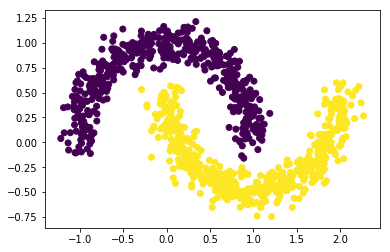

In [0]:
# Importing the data and plotting it.

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X_moons, y_moons = make_moons(n_samples=1000, random_state=42, noise=0.1)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
plt.show()

In [0]:
# Adding a bias term term to the inputs

X_moons_plus_bias = np.c_[np.ones((X_moons.shape[0], 1)), X_moons]
y_moons_reshaped = y_moons.reshape(-1, 1)

In [0]:
# Defining the computational graph for Logistic Regression.

root_logdir = 'log_reg'

def logistic_regression(X, y, n_features, learning_rate=0.01, momentum=0.9):
  with tf.name_scope('model'):
    theta = tf.Variable(tf.random_uniform([n_features, 1], -1., 1.), name='theta')
    y_proba = tf.math.sigmoid(tf.matmul(X, theta))
  with tf.name_scope('train'):
    loss = tf.losses.log_loss(y, y_proba)
    optimizer = \
      tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
    training_op = optimizer.minimize(loss)
  with tf.name_scope('init'):
    init = tf.global_variables_initializer()
  now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
  logdir = '{}/run-{}/'.format(root_logdir, now)
  with tf.name_scope('saver'):
    loss_summary = tf.summary.scalar('Loss', loss)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    saver = tf.train.Saver()
  return y_proba, loss, training_op, init, loss_summary, file_writer, saver

In [0]:
# Define procedure for training the data

import os

def fetch_batch(X_source, epoch, batch_size, batch_idx):
  np.random.seed((epoch * batch_size) + batch_idx)
  rand_idx = np.random.randint(X_moons_plus_bias.shape[0], size=batch_size)
  return X_source[rand_idx], y_moons_reshaped[rand_idx]

def save_model(saver, sess, model_path, epoch):
  saver.save(sess, model_path)
  with open('{}.epoch'.format(model_path), 'w') as f:
    f.write(str(epoch))
    f.close()

def train_logistic_regression(X_source, initializer, n_epochs, n_batches,
                              batch_size, training_op, X, y, model_path, saver,
                              loss_summary, file_writer, y_proba):
  with tf.Session() as sess:
    if os.path.isfile(model_path):
      saver.restore(sess, model_path)
      with open('{}.epoch'.format(model_path)) as f:
        start_epoch = int(f.read())
    else:
      sess.run(initializer)
      start_epoch = 0
    for epoch in range(start_epoch, n_epochs):
      if epoch % 10 == 0:
        save_model(saver, sess, model_path, epoch)
      for batch_idx in range(n_batches):
        X_batch, y_batch = fetch_batch(X_source, epoch, batch_size, batch_idx)
        if batch_idx % 10 == 0:
          summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
          file_writer.add_summary(summary_str,
                                  (epoch * batch_size) + batch_idx)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    save_model(saver, sess, model_path, n_epochs)
    file_writer.close()
    return y_proba.eval(feed_dict={X: X_source, y: y_moons_reshaped})

In [0]:
# Training a model and looking at the results

n_features = X_moons_plus_bias.shape[1]

reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

y_proba, loss, training_op, init, loss_summary, file_writer, saver = \
  logistic_regression(X, y, n_features)

n_epochs = 100
batch_size = 50
n_batches = int(np.ceil(X_moons_plus_bias.shape[0] / batch_size))

y_proba_val = \
  train_logistic_regression(X_moons_plus_bias, init, n_epochs, n_batches,
                            batch_size, training_op, X, y, 'tmp/log_reg.ckpt',
                            saver, loss_summary, file_writer, y_proba)

In [0]:
# Testing the accracy, precision, and recall on the training set.

from sklearn.metrics import accuracy_score, precision_score, recall_score

y_pred = (y_proba_val >= 0.5).flatten()
print('Accuracy: {}'.format(accuracy_score(y_moons, y_pred)))
print('Precision: {}'.format(precision_score(y_moons, y_pred)))
print('Recall: {}'.format(recall_score(y_moons, y_pred)))

Accuracy: 0.877
Precision: 0.8777555110220441
Recall: 0.876


In [0]:
# Taking a look in Tensorboard

get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'.format(root_logdir))
get_ipython().system_raw('./ngrok http 6007 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://a4072b01.ngrok.io


In [0]:
# Trying to add polynomial features, since Logistic Regression is a linear
# model and the moons dataset is very clearly nonlinear.

from sklearn.preprocessing import PolynomialFeatures

X_moons_poly = PolynomialFeatures(degree=4).fit_transform(X_moons)
X_moons_poly_plus_bias = np.c_[np.ones((X_moons_poly.shape[0], 1)),
                               X_moons_poly]

In [0]:
# Retraining the model with the new feature set.

n_features = X_moons_poly_plus_bias.shape[1]

reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

y_proba, loss, training_op, init, loss_summary, file_writer, saver = \
  logistic_regression(X, y, n_features)

n_epochs = 100
batch_size = 50
n_batches = int(np.ceil(X_moons_poly_plus_bias.shape[0] / batch_size))

y_proba_val = \
  train_logistic_regression(X_moons_poly_plus_bias, init, n_epochs, n_batches,
                            batch_size, training_op, X, y, 'tmp/log_reg2.ckpt',
                            saver, loss_summary, file_writer, y_proba)

In [0]:
# Adding polynomial features improved the model greatly.

y_pred = (y_proba_val >= 0.5).flatten()
print('Accuracy: {}'.format(accuracy_score(y_moons, y_pred)))
print('Precision: {}'.format(precision_score(y_moons, y_pred)))
print('Recall: {}'.format(recall_score(y_moons, y_pred)))

Accuracy: 0.982
Precision: 0.9781746031746031
Recall: 0.986


In [0]:
# Experimenting with different batch sizes and learning rates.

from scipy.stats import uniform, reciprocal

def search_parameters(n_iterations):
  rand_batch_sizes = [int(r) for r in uniform.rvs(40, 60, size=n_iterations)]
  rand_learning_rates = reciprocal.rvs(0.01, 0.1, size=n_iterations)
  for it in range(n_iterations):
    batch_size = rand_batch_sizes[it]
    learning_rate = rand_learning_rates[it]
    
    print('Iteration: {}'.format(it))
    print('Batch Size:', batch_size)
    print('Learning Rate:', learning_rate)
    print('-------')
    
    n_features = X_moons_poly_plus_bias.shape[1]

    reset_graph()
    X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
    y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

    y_proba, loss, training_op, init, loss_summary, file_writer, saver = \
      logistic_regression(X, y, n_features, learning_rate)
    
    n_epochs = 100
    n_batches = int(np.ceil(X_moons_poly_plus_bias.shape[0] / batch_size))

    y_proba_val = \
      train_logistic_regression(X_moons_poly_plus_bias, init, n_epochs,
                                n_batches, batch_size, training_op, X, y,
                                'tmp/log_reg_search_{}.ckpt'.format(it), saver,
                                loss_summary, file_writer, y_proba)
    
    y_pred = (y_proba_val >= 0.5).flatten()
    print('Accuracy: {}'.format(accuracy_score(y_moons, y_pred)))
    print('Precision: {}'.format(precision_score(y_moons, y_pred)))
    print('Recall: {}'.format(recall_score(y_moons, y_pred)))
    print('======')

In [0]:
search_parameters(10)

Iteration: 0
Batch Size: 61
Learning Rate: 0.07072597620496644
-------
Accuracy: 0.998
Precision: 0.9960159362549801
Recall: 1.0
Iteration: 1
Batch Size: 74
Learning Rate: 0.06647624407312398
-------
Accuracy: 0.998
Precision: 0.9960159362549801
Recall: 1.0
Iteration: 2
Batch Size: 44
Learning Rate: 0.04493194233490411
-------
Accuracy: 0.998
Precision: 0.9960159362549801
Recall: 1.0
Iteration: 3
Batch Size: 77
Learning Rate: 0.028212149592946142
-------
Accuracy: 0.989
Precision: 0.9860834990059643
Recall: 0.992
Iteration: 4
Batch Size: 70
Learning Rate: 0.016721593511578182
-------
Accuracy: 0.985
Precision: 0.9840319361277445
Recall: 0.986
Iteration: 5
Batch Size: 43
Learning Rate: 0.07933213656615368
-------
Accuracy: 0.998
Precision: 0.9960159362549801
Recall: 1.0
Iteration: 6
Batch Size: 84
Learning Rate: 0.0331489463665092
-------
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
Iteration: 7
Batch Size: 98
Learning Rate: 0.015446215925526047
-------
Accuracy: 0.978
Precision: 0.97609